In [ ]:
!nvidia-smi

Wed Apr 26 15:23:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!python --version
!pip install transformers --quiet
!pip install pytorch-lightning --quiet

Python 3.9.16
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 52.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 79.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 47.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 52.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.4/269.4 kB 902.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 13.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizerFast as BertTokenizer, BertModel, AutoTokenizer, AutoModel, AdamW, get_linear_schedule_with_warmup

import pytorch_lightning as pl
from torchmetrics.functional import auroc, accuracy
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix
from sklearn.model_selection import KFold

import seaborn as sns        
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

#Import Train / Test Data for Subtask B

In [ ]:
!gdown --id 1TjVUD5MRPqlAjINhFfRM2vJpB0iaZm6w

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1TjVUD5MRPqlAjINhFfRM2vJpB0iaZm6w
To: /content/cleaned_train_data_v1.csv
100% 2.90M/2.90M [00:00<00:00, 195MB/s]


In [ ]:
df1 = pd.read_csv("cleaned_train_data_v1.csv")
df1.head()

,del,id,tweet,subtask_a,subtask_b,subtask_c,cleaned_tweet
0,0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN,ask native americans take
1,1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND,go home drunk maga trump 2020
2,2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN,amazon investigating chinese employees selling...
3,3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN,someone vetaken piece shit volcano
4,4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN,obama wanted liberals illegals move red states


##Data Pre-processing

In [ ]:
df1[df1['cleaned_tweet'].isnull()]

,del,id,tweet,subtask_a,subtask_b,subtask_c,cleaned_tweet
419,419,32122,@USER All of them! 😂😂 URL,NOT,NaN,NaN,NaN
847,847,75079,@USER he is,NOT,NaN,NaN,NaN
995,995,67744,@USER @USER He is.,NOT,NaN,NaN,NaN
1022,1022,62559,@USER she is 😩,NOT,NaN,NaN,NaN
1315,1315,31487,@USER There you are! 👋🐾,NOT,NaN,NaN,NaN
...,...,...,...,...,...,...,...
11679,11679,12502,@USER You are...,NOT,NaN,NaN,NaN
12328,12328,51297,@USER @USER She is a 🤡,OFF,TIN,IND,NaN
12615,12615,19557,"@USER He is.""""",NOT,NaN,NaN,NaN
12872,12872,85713,@USER @USER @USER He is.,NOT,NaN,NaN,NaN


In [ ]:
# Select Columns of interest
BTrainData = df1[["cleaned_tweet", "subtask_b"]]
BTrainData = BTrainData[BTrainData['cleaned_tweet'].notna()]
BTrainData = BTrainData[BTrainData['subtask_b'].notna()]

print(BTrainData.shape)
BTrainData.head()

(4396, 2)


,cleaned_tweet,subtask_b
0,ask native americans take,UNT
1,go home drunk maga trump 2020,TIN
3,someone vetaken piece shit volcano,UNT
5,liberals kookoo,TIN
6,oh noes tough shit,UNT


In [ ]:
BTrainData['subtask_b'].value_counts()

TIN    3872
UNT     524
Name: subtask_b, dtype: int64

[3872, 524]


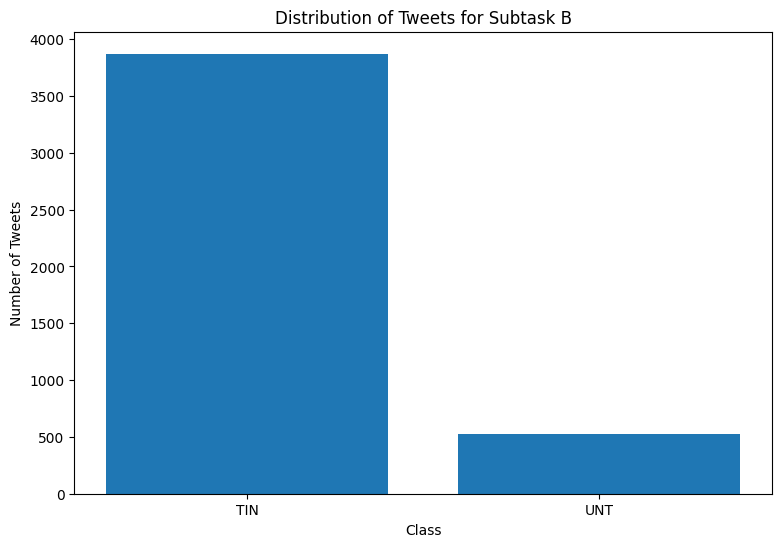

In [ ]:
B_LABELS = ["TIN", "UNT"]
# B_LABELS
fig = plt.figure(figsize=(9, 6))
y = [(BTrainData['subtask_b'] == label).sum() for label in B_LABELS]
print(y)
# ax.bar(A_LABELS, y)
plt.bar(B_LABELS, y)
plt.xlabel("Class")
plt.ylabel("Number of Tweets")
plt.title("Distribution of Tweets for Subtask B")
plt.show()

The number of Tweets that are Targeted Intentional Insults and Threats completely dominates the number of reviews for Untargeted Threats. To solve this imbalance we will under-sample the TIN class. 

In [ ]:
#convert to one hot encoding: 1 if TIN, 0 if UNT
BTrainData['subtask_b'] = BTrainData['subtask_b'].apply(lambda x: 1 if x=='TIN' else 0)
BTrainData.head()

,cleaned_tweet,subtask_b
0,ask native americans take,0
1,go home drunk maga trump 2020,1
3,someone vetaken piece shit volcano,0
5,liberals kookoo,1
6,oh noes tough shit,0


In [ ]:
numUNTTweets = (BTrainData['subtask_b'] == 0).sum()
numUNTTweets

524

In [ ]:
TINtweets = BTrainData.loc[BTrainData['subtask_b'] == 1]
TINtweets.shape

(3872, 2)

Randomly Sample TIN Tweets 524 times to undersample our dataset

In [ ]:
sampleTIN = TINtweets.sample(n=numUNTTweets, random_state=1)
print(sampleTIN.shape)

(524, 2)


In [ ]:
UNTtweets = BTrainData.loc[BTrainData['subtask_b'] == 0]
train_df = pd.concat([sampleTIN, UNTtweets]).sample(frac=1)
print(train_df.shape)
train_df

(1048, 2)


,cleaned_tweet,subtask_b
5126,find offensive know black people feel black af...,1
6513,yeah guess helped dc become murder capital wor...,1
11364,shame tennis hierarchy stole serena proven dra...,1
12377,may well ignore since giving attention craves ...,1
9783,boy hollywood sure like look like fools time w...,0
...,...,...
11553,also said gatlin gun niggas sit corner like bo...,1
8792,technically speaking hamstrung drug alcohol ad...,0
1533,100 true stupid well,0
4761,pope satan incarnate,1


[524, 524]


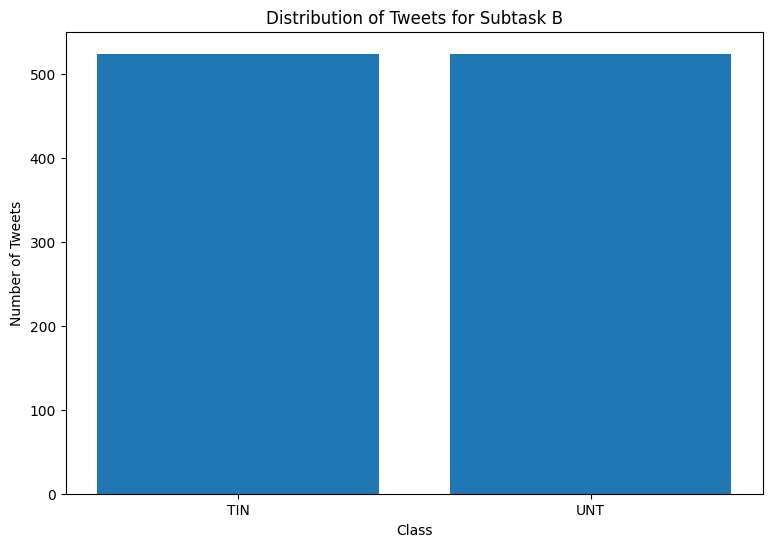

In [ ]:
B_LABELS = ["TIN", "UNT"]
class_labels = [1, 0]
# B_LABELS
fig = plt.figure(figsize=(9, 6))
y = [(train_df['subtask_b'] == label).sum() for label in class_labels]
print(y)
# ax.bar(A_LABELS, y)
plt.bar(B_LABELS, y)
plt.xlabel("Class")
plt.ylabel("Number of Tweets")
plt.title("Distribution of Tweets for Subtask B")
plt.show()
B_LABELS = ["UNT", "TIN"]

The two classes are now balanced.

##Prepare Validation Test Set

In [ ]:
!gdown 1NFIS8iQ0j4R_GdbH0Zl8J2n1CbzqusHv
!gdown 1rsVgv2QuPJOmr6gO8FUo4ru3rdzzdPnn

Downloading...
From: https://drive.google.com/uc?id=1NFIS8iQ0j4R_GdbH0Zl8J2n1CbzqusHv
To: /content/labels-levelb.csv
100% 2.40k/2.40k [00:00<00:00, 4.96MB/s]
Downloading...
From: https://drive.google.com/uc?id=1rsVgv2QuPJOmr6gO8FUo4ru3rdzzdPnn
To: /content/testset-levelb.tsv
100% 35.4k/35.4k [00:00<00:00, 59.2MB/s]


In [ ]:
df2 = pd.read_csv("labels-levelb.csv", names=["id", "subtask_b"])
print(df2.shape)
df2.head()

(240, 2)


,id,subtask_b
0,15923,TIN
1,60133,TIN
2,83681,TIN
3,65507,TIN
4,12588,UNT


In [ ]:
df3 = pd.read_csv("testset-levelb.tsv", sep='\t')
print(df3.shape)
df3.head()

(240, 2)


,id,tweet
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...
1,60133,#NoPasaran: Unity demo to oppose the far-right...
2,83681,. . . What the fuck did he do this time?
3,65507,@USER Do you get the feeling he is kissing @US...
4,12588,@USER Nigga ware da hits at


In [ ]:
val_df = pd.merge(df2, df3, on='id', how='outer')
print(val_df.shape)
val_df = val_df.rename(columns={"tweet": "cleaned_tweet"}) ############################
val_df.head()
val_df['subtask_b'].value_counts()

(240, 3)


TIN    213
UNT     27
Name: subtask_b, dtype: int64

In [ ]:
val_df = val_df[val_df['cleaned_tweet'].notna()]
val_df = val_df[val_df['subtask_b'].notna()]

#convert to one hot encoding: 1 if TIN, 0 otherwise
val_df['subtask_b'] = val_df['subtask_b'].apply(lambda x: 1 if x=='TIN' else 0)
print(val_df.shape)
val_df.head()


(240, 3)


,id,subtask_b,cleaned_tweet
0,15923,1,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...
1,60133,1,#NoPasaran: Unity demo to oppose the far-right...
2,83681,1,. . . What the fuck did he do this time?
3,65507,1,@USER Do you get the feeling he is kissing @US...
4,12588,0,@USER Nigga ware da hits at


In [ ]:
val_df['subtask_b'].value_counts()

1    213
0     27
Name: subtask_b, dtype: int64

#Tokenizer

In [ ]:
BERT_MODEL_NAME = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)

In [ ]:
token_counts = []

for _, row in train_df.iterrows():
  count = len(tokenizer.encode(
    row['cleaned_tweet'], 
    max_length=512, 
    truncation=True))
  token_counts.append(count)
  

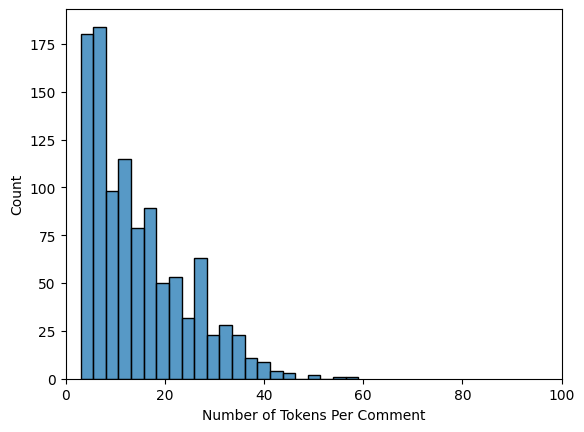

In [ ]:
sns.histplot(token_counts)
plt.xlabel("Number of Tokens Per Comment")
plt.xlim([0, 100]);

Set MAX_TOKEN_COUNT = 50

In [ ]:
MAX_TOKEN_COUNT = 50

#PyTorch Dataset

In [ ]:
class TweetDataset(Dataset):
  def __init__(self, data: pd.DataFrame, tokenizer: AutoTokenizer, max_token_len: int=128):
    self.data = data
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len

  def __len__(self):
    return len(self.data)
  
  ## return encoding of review
  def __getitem__ (self, index: int):
    data_row = self.data.iloc[index]
    tweet = data_row['cleaned_tweet']
    label = data_row['subtask_b']
    encoding = self.tokenizer.encode_plus(
        tweet,
        add_special_tokens=True,
        max_length=self.max_token_len,
        return_token_type_ids=False,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_tensors="pt"
    )

    return dict(
        tweet=tweet,
        input_ids=encoding["input_ids"].flatten(),
        attention_mask=encoding["attention_mask"].flatten(),
        label=torch.FloatTensor([label])
    )    

Set up PyTorch DataModule

The final step is to wrap our dataset into a lightningDataModule

In [ ]:
class TweetDataModule(pl.LightningDataModule):
  def __init__(self, train_df, test_df, tokenizer, batch_size=8, max_token_len=128):
    super().__init__()
    self.train_df = train_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.batch_size = batch_size
    self.max_token_len = max_token_len

  # create dataset for each of the training and test sets
  def setup(self, stage=None):
    self.train_dataset = TweetDataset(
        self.train_df,
        self.tokenizer,
        self.max_token_len
    )
    self.test_dataset = TweetDataset(
        self.test_df,
        self.tokenizer,
        self.max_token_len
    )

  def train_dataloader(self):
    return DataLoader(
        self.train_dataset,
        batch_size=self.batch_size,
        shuffle=True,
        num_workers=4
    )
    
  # make predictions on a single example (single batch size)
  def val_dataloader(self):
    return DataLoader(
        self.test_dataset,
        batch_size=self.batch_size,
        num_workers=4
    )
  
  def test_dataloader(self):
    return DataLoader(
        self.test_dataset,
        batch_size=self.batch_size,
        num_workers=4
    )

#Build Model

In [ ]:
from torch.optim import lr_scheduler
class OffensiveTweetTagger(pl.LightningModule):
  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    super().__init__()
    self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
    # classifier: serve as a way to get the output of the BERT model and convert those into the num of classes which we want to predict
    self.classifier1 = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.dropOutLayer = nn.Dropout(p=0.1)
    self.relu = nn.ReLU()
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.classifier2 = nn.Linear(n_classes, 1)
    # This criterion computes the cross entropy loss between input logits and target
    self.criterion = nn.BCELoss()
    

  def forward(self, input_ids, attention_mask, labels=None):
    output = self.bert(input_ids, attention_mask=attention_mask)
    # run linear layer ontop of the output
    output = self.classifier1(output.pooler_output)
    output = self.relu(output)
    output = self.dropOutLayer(output)
    output = self.classifier2(output)
    # apply sigmoid function
    output = torch.sigmoid(output)
    loss = 0
    if labels is not None:
      loss = self.criterion(output, labels)
    return loss, output

  def training_step(self, batch, batch_idx):
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    labels = batch['label']
    loss, outputs = self.forward(input_ids, attention_mask, labels)
    # output training loss
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}

  def validation_step(self, batch, batch_idx):
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    labels = batch['label']
    loss, outputs = self.forward(input_ids, attention_mask, labels)
    # output training loss
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss
  
  def test_step(self, batch, batch_idx):
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    labels = batch['label']
    loss, outputs = self.forward(input_ids, attention_mask, labels)
    # output training loss
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss

  # configer optimisers and learning rate scheduler
  def configure_optimizers(self):
    # fine tuning recomendations from original BERT paper
    # Recommended learning rates (Adam): 5e-5, 3e-5, 2e-5. See: https://arxiv.org/pdf/1810.04805.pdf
    optimizer = AdamW(self.parameters(), lr=2e-5)
  
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=self.n_warmup_steps,
        num_training_steps=self.n_training_steps
    )

    # return a list of optimisers and schedulers
    return dict(
        optimizer=optimizer,
        lr_scheduler=dict(
            scheduler=scheduler,
            interval='step'
        )
    )

Optimizer explanation: 
If we simulate 100 training steps and tell the scheduler to warm up for the first 20. The learning rate grows to the initial fixed value of 0.001 during the warm-up and then goes down (linearly) to 0.

To use the scheduler, we need to calculate the number of training and warm-up steps. The number of training steps per epoch is equal to number of training examples / batch size. The number of total training steps is training steps per epoch * number of epochs:

In [ ]:
train_df

,cleaned_tweet,subtask_b
5126,find offensive know black people feel black af...,1
6513,yeah guess helped dc become murder capital wor...,1
11364,shame tennis hierarchy stole serena proven dra...,1
12377,may well ignore since giving attention craves ...,1
9783,boy hollywood sure like look like fools time w...,0
...,...,...
11553,also said gatlin gun niggas sit corner like bo...,1
8792,technically speaking hamstrung drug alcohol ad...,0
1533,100 true stupid well,0
4761,pope satan incarnate,1


#Train Model using 80%-20% train-test split

In [ ]:
N_EPOCHS = 4
BATCH_SIZE =  8
MAX_TOKEN_COUNT = 50

BERT_MODEL_NAME = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)

train_df_fold, val_df_fold = train_test_split(train_df, test_size=0.20)

data_module = TweetDataModule(
    train_df_fold,
    val_df_fold,
    tokenizer,
    batch_size=BATCH_SIZE,
    max_token_len=MAX_TOKEN_COUNT
)

steps_per_epoch = len(train_df_fold) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS
warmup_steps = total_training_steps // 5

model = OffensiveTweetTagger(
  n_classes=len(B_LABELS),
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps
)

# Run on GPU
model.cuda()

checkpoint_callback = ModelCheckpoint(
  dirpath="subtask_b/train_test_split",
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min",
  save_weights_only=True
)

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

trainer = pl.Trainer(
  callbacks=[early_stopping_callback, checkpoint_callback],
  max_epochs=N_EPOCHS
)

trainer.fit(model, data_module)
trainer.test(model, data_module)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 105: 'val_loss' reached 0.68104 (best 0.68104), saving model to '/content/subtask_b/train_test_split/best-checkpoint-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 210: 'val_loss' reached 0.67612 (best 0.67612), saving model to '/content/subtask_b/train_test_split/best-checkpoint-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 315: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 420: 'val_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=4` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.7197079062461853     │
└───────────────────────────┴───────────────────────────┘

  0%|          | 0/240 [00:00<?, ?it/s]

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

val_dataset = TweetDataset(
  val_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

predictions = []
labels = []

with torch.no_grad(): 
  for item in tqdm(val_dataset):
    input_ids = item["input_ids"].unsqueeze(dim=0)
    attention_mask = item["attention_mask"].unsqueeze(dim=0)
    input_ids.to(device)
    attention_mask.to(device)
    _, prediction = model(
      input_ids,
      attention_mask
    )
    predictions.append(prediction.flatten())
    labels.append(item["label"].int())

  predictions = torch.stack(predictions).detach().cpu()
  labels = torch.stack(labels).detach().cpu()

In [ ]:
# Calculate Accuracy of Model
model_accuracy = accuracy(task="binary", preds=predictions, target=labels)
print("Accuracy: ", model_accuracy)

Accuracy:  tensor(0.7625)


In [ ]:
y_pred = predictions.numpy()
y_true = labels.numpy()

upper, lower = 1, 0

y_pred = np.where(y_pred > 0.5, upper, lower)

print(classification_report(
  y_true,
  y_pred,
  target_names=B_LABELS,
  zero_division=0
))

              precision    recall  f1-score   support

         UNT       0.28      0.70      0.40        27
         TIN       0.95      0.77      0.85       213

    accuracy                           0.77       240
   macro avg       0.62      0.74      0.63       240
weighted avg       0.88      0.77      0.80       240



# Load in Saved Model

In [ ]:
trained_model = OffensiveTweetTagger.load_from_checkpoint(
  "/content/subtask_b/train_test_split/subtask_b_best_model.ckpt",
  n_classes=len(B_LABELS)
)
trained_model.eval()
trained_model.freeze()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Predicting unseen tweet using the trained model

In [ ]:
test_tweet= "@USER Look at all these racist white liberals freaking out because I said Tom Arnold has white privileged."

THRESHOLD = 0.5

encoding = tokenizer.encode_plus(
    test_tweet,
    add_special_tokens=True,
    max_length=50,
    return_token_type_ids=False,
    padding="max_length",
    return_attention_mask=True,
    return_tensors='pt',
)

trained_model.to('cpu')
encoding.to('cpu')

_, test_prediction = trained_model(encoding['input_ids'], encoding['attention_mask'])
test_prediction = test_prediction.flatten().numpy()


In [ ]:
test_prediction

array([0.5197463], dtype=float32)

In [ ]:
print("Tweet: ", test_tweet)
if(test_prediction[0] > THRESHOLD):
  print("Result: This tweet is TIN")
else:
  print("Result: This tweet is UNT")

Tweet:  @USER Look at all these racist white liberals freaking out because I said Tom Arnold has white privileged.
Result: This tweet is TIN
